In [12]:
%pip install matplotlib
%pip install numpy==1.23.5
%pip install opencv-python
%pip install medpy==0.4.0
%pip install tqdm
%matplotlib inline
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import sys
import os
plt.rcParams["figure.figsize"] = (15,15)

print(f"numpy version : {np.__version__}")

%load_ext autoreload
%autoreload 2

numpy version : 1.23.5
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
tf.test.is_gpu_available()

True

In [15]:
# from keras_unet.losses import dice_loss
# from keras_unet.metrics import dice_coef, iou, iou_thresholded
from keras_unet.visualization import plot_overlay_segmentation
from keras_unet.visualization import plot_compare_segmentation
from keras_unet.visualization import visualize_BestWorstOnes

# Add our own python modules stored in the folders present at the root level of this project
if "../" in sys.path: 
    print(sys.path)
else: 
    sys.path.append("../")
    print(sys.path)

if "model" in locals(): 
    print("deleting model")
    del model    
    
# Select the CPU device to run on
num_CPU = 1
num_cores = 8
tf.config.threading.set_intra_op_parallelism_threads(num_CPU)
tf.config.threading.set_inter_op_parallelism_threads(num_cores)
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3" 

['c:\\Users\\user\\Desktop\\zhuyi\\PTI\\camus-hands-on-main', 'c:\\Users\\user\\anaconda3\\envs\\py310\\python310.zip', 'c:\\Users\\user\\anaconda3\\envs\\py310\\DLLs', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib', 'c:\\Users\\user\\anaconda3\\envs\\py310', '', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib\\site-packages', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib\\site-packages\\win32', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib\\site-packages\\win32\\lib', 'c:\\Users\\user\\anaconda3\\envs\\py310\\lib\\site-packages\\Pythonwin', '../']
deleting model


## <span style="color:brown"> 1.1) Load data

In [16]:
from keras_unet.utils import load_CAMUS_dataset

# Parameters
IMG_SIZE = 256  # All the images will be resized to IMG_SIZE x IMG_SIZE to speed up the process. 

# dataset_train_path = "dataset/segmentation/train/"
# dataset_valid_path = "dataset/segmentation/valid/"
dataset_test_path = "dataset/segmentation/test/"

# Load data
# [X_train, y_train] = load_CAMUS_dataset(dataset_train_path, IMG_SIZE)
# [X_valid, y_valid] = load_CAMUS_dataset(dataset_valid_path, IMG_SIZE)
[X_test, y_test] = load_CAMUS_dataset(dataset_test_path, IMG_SIZE)

100%|██████████| 100/100 [00:00<00:00, 2086.50it/s]


randomly picked indices : [10 35]


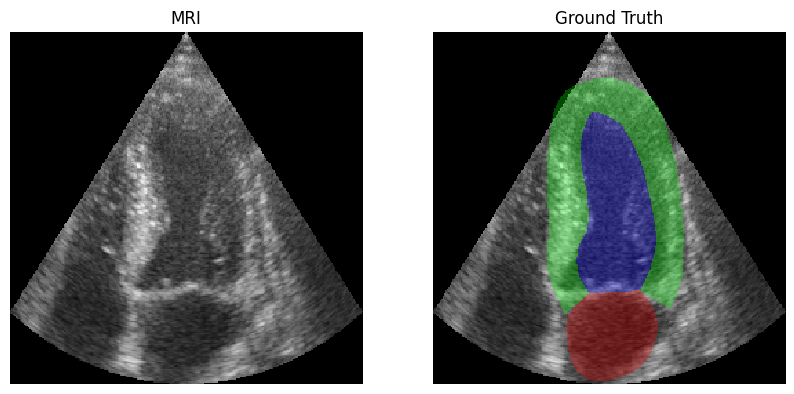

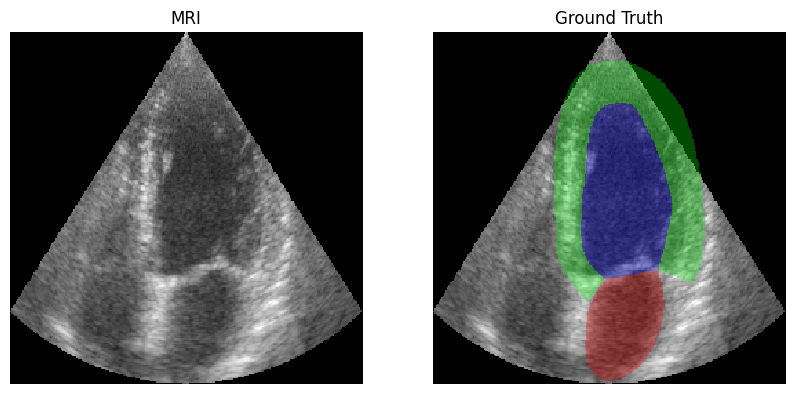

In [17]:
from keras_unet.visualization import plot_superposition
from tqdm import tqdm

nb = 2
ixs = np.random.choice(len(X_test), nb) 
print(f'randomly picked indices : {ixs}')
plot_overlay_segmentation(X_test[ixs, ], y_test[ixs,])

## Load a trained model

In [18]:
from tensorflow.keras import models
from keras_unet.losses import dice_loss
from keras_unet.metrics import dice_coef

model_path = './trained_model/trained_Unet_f32_b16_l4_do0.1_Std_BN_input_epoch_176.h5'
model = models.load_model(model_path, 
              custom_objects={'dice_coef': dice_coef, 'dice_loss': dice_loss})    

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Prediction

In [19]:
from keras_unet.evaluation import  evaluate_segmentation, evaluate_set_each, evaluate_set_avr
import pandas as pd
from IPython.display import display, HTML 

# Predict segmentations on the full test dataset
y_pred = model.predict(X_test, batch_size=1, verbose=1)

# # make the prediction labels correspond to those of the new GT 
y_pred[:,:,:,1] = y_pred[:,:,:,3]
y_pred = np.delete(y_pred,-1,axis=-1)

y_pred.shape

100/100 [==============================] - 1s 11ms/step


(100, 256, 256, 3)

# Evaluation

In [23]:
df = evaluate_set_each(y_test, y_pred, voxel_spacing = [1.0, 1.0],
                  labels = ["All", "Right Ventricle", "Myocardium", "Left Ventricle"])
df.head() 

100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


Dice                                            Hausdorff  \
                  All Right Ventricle Myocardium Left Ventricle        All   
image index                                                                  
0            0.908508        0.949102   0.849357       0.935615   8.544004   
1            0.873079         0.95417   0.807527       0.895519  10.198039   
2             0.88303        0.896959    0.87674       0.875375   8.602325   
3            0.882804        0.909195   0.838323       0.922639   9.433981   
4            0.898907        0.905038   0.856298       0.940336        8.0   

                                                           ASSD  \
            Right Ventricle Myocardium Left Ventricle       All   
image index                                                       
0                  6.708204   8.544004       7.615773  2.303759   
1                  6.403124  10.198039       8.062258  2.839543   
2                       8.0   8.246211       8.602325   2.82316   
3                  4.242641   9.433981       6.403124  2.382117   
4                   7.81025        8.0       5.385165  2.612199   

                                                       
            Right Ventricle Myocardium Left Ventricle  
image index                                            
0                  1.891766    2.73049        2.28902  
1                    1.5016   3.863298       3.153731  
2                  3.327004   2.398423       2.744052  
3                  2.334219   2.658824       2.153308  
4                  2.602943   2.807916       2.425737

[30 58 60 27]


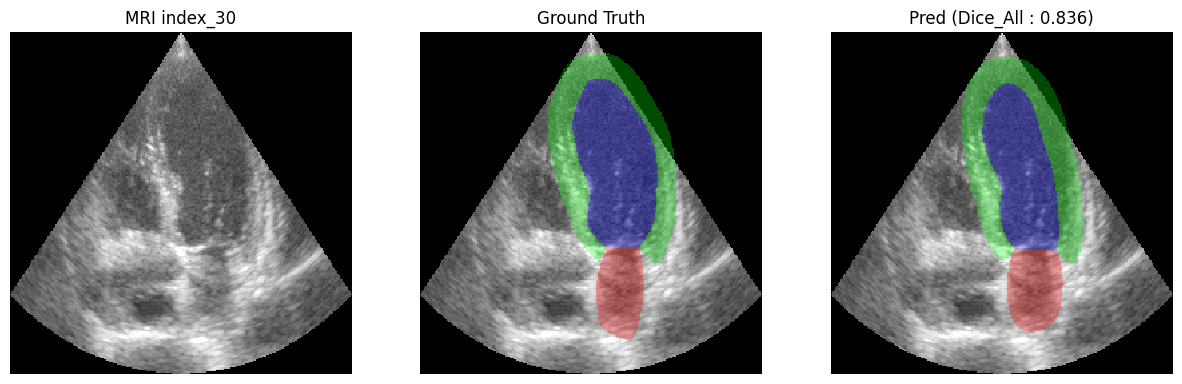

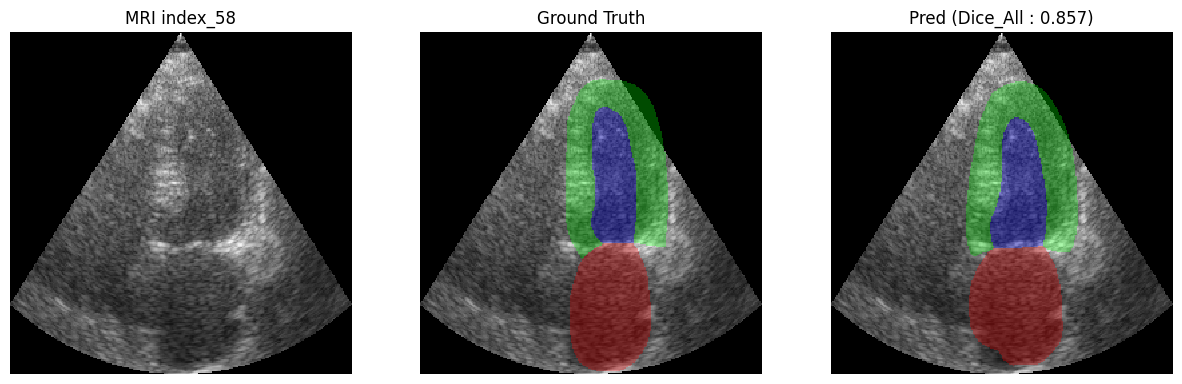

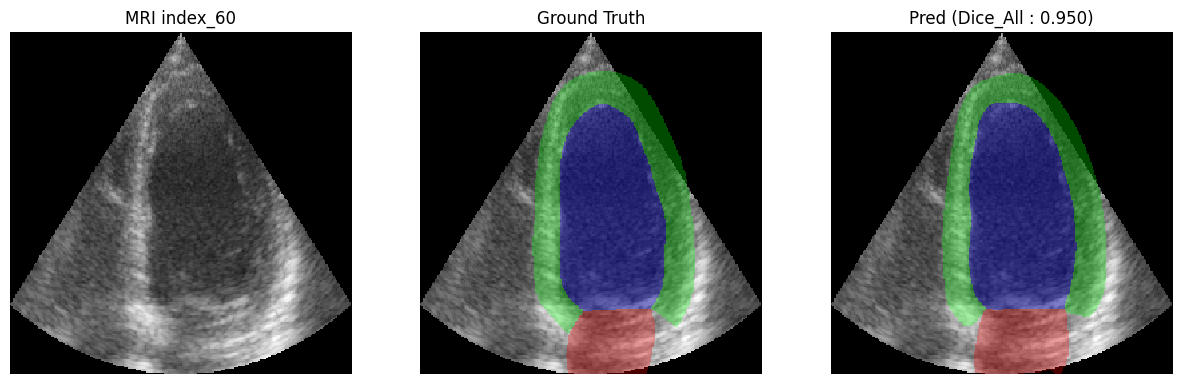

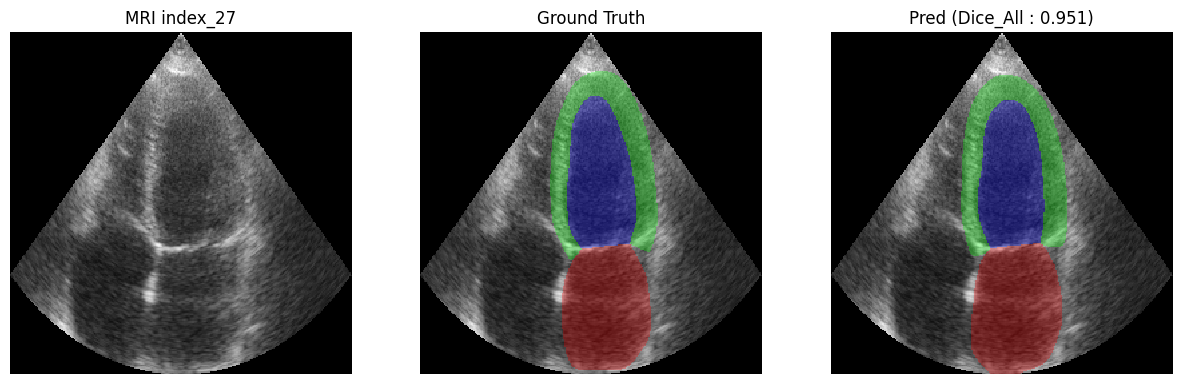

In [24]:
### Parameters to specify ###

metric = 'Dice'
label = 'All'
nb_show = 2
show_best = True
show_worst = True

##################################################################

ixs_show = []
ixs_ascend_sort = df.loc[:,(metric, label)].argsort().values # ascending order
if show_worst:
    ixs_worst = ixs_ascend_sort[:nb_show]
    ixs_show.append(ixs_worst)
if show_best:
    ixs_best = ixs_ascend_sort[-nb_show:]
    ixs_show.append(ixs_best)
ixs_show = np.concatenate(ixs_show)
print(ixs_show)

# Prepare titles
metric_values = df.loc[:,(metric, label)][ixs_show].values

titles_for_imgs = []
for ix in ixs_show:
    titles_for_imgs.append(f'MRI index_{ix}')

titles_for_preds = []
for value in metric_values:
    titles_for_preds.append(f"Pred ({metric}_{label} : {value:.3f})")

plot_compare_segmentation(X_test[ixs_show, ], y_test[ixs_show,], y_pred[ixs_show,], 
                          " ", spacing=(1,1), step=1, img_titles=titles_for_imgs,
                          pred_titles=titles_for_preds)

100/100 [==============================] - 5s 48ms/step


100%|██████████| 100/100 [00:03<00:00, 26.07it/s]


,Dice,Hausdorff (px),ASSD (px)
All,0.91,10.16,2.37
Right Ventricle,0.89,8.52,2.95
Myocardium,0.88,8.46,2.15
Left Ventricle,0.94,6.84,2.01


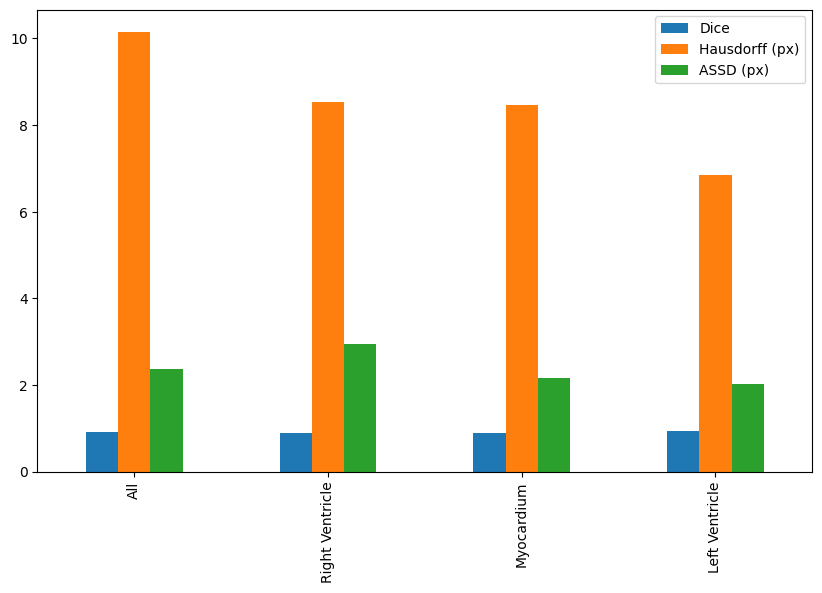

In [25]:
from keras_unet.evaluation import  evaluate_segmentation, evaluate_set_avr, evaluate_set_each
import pandas as pd
from IPython.display import display, HTML 

# Predict segmentations on the full test dataset
y_pred = model.predict(X_test, batch_size=1, verbose=1)

# Compute score on the full test dataset
dice_all, hausdorff_all, assd_all, valid_all = evaluate_set_avr(y_test, y_pred)

# Put the results into a matrix and graft it into a pandas data frame (object from the panda library)
overall_results = np.column_stack((dice_all, hausdorff_all, assd_all))
overall_results_df = pd.DataFrame(data=overall_results, index = ["All", "Right Ventricle", "Myocardium", "Left Ventricle"], 
                                  columns=["Dice", "Hausdorff (px)", "ASSD (px)"]) 

# Display the data as HTML tables and graphs
display(HTML(overall_results_df.to_html(float_format=lambda x: '%.2f' % x)))
overall_results_df.plot(kind='bar', figsize=(10,6)).legend() #bbox_to_anchor=(1.6,0.9))

,Max Score,Median Score,Min Score
All,0.95,0.91,0.84
Right Ventricle,0.97,0.90,0.69
Myocardium,0.93,0.89,0.77
Left Ventricle,0.98,0.95,0.79


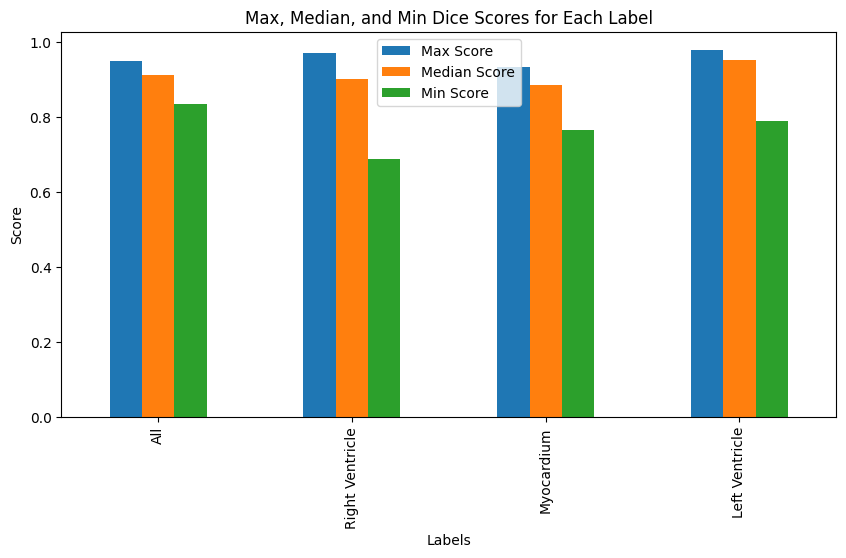

,Max Score,Median Score,Min Score
All,28.46,9.67,4.47
Right Ventricle,28.46,7.81,3.61
Myocardium,15.30,8.06,4.12
Left Ventricle,14.87,6.40,2.24


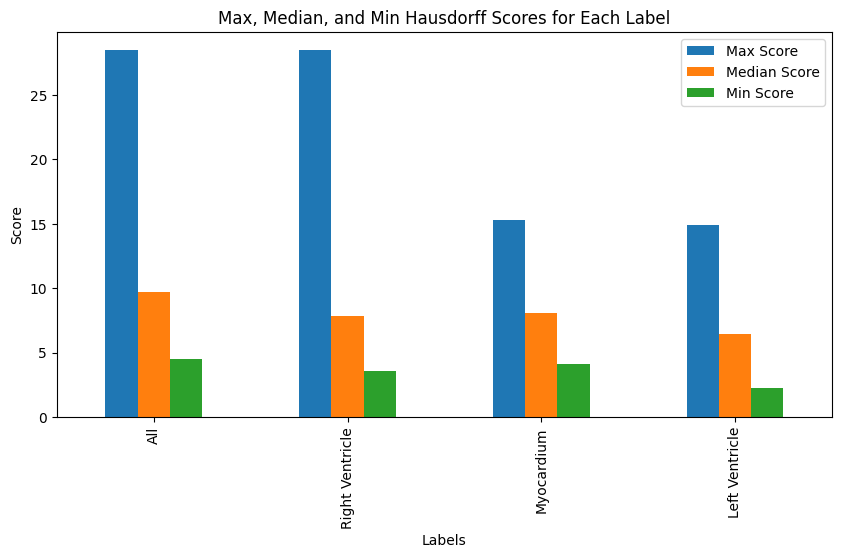

,Max Score,Median Score,Min Score
All,3.71,2.32,1.18
Right Ventricle,6.63,2.77,1.09
Myocardium,3.98,2.07,1.04
Left Ventricle,4.42,1.89,0.77


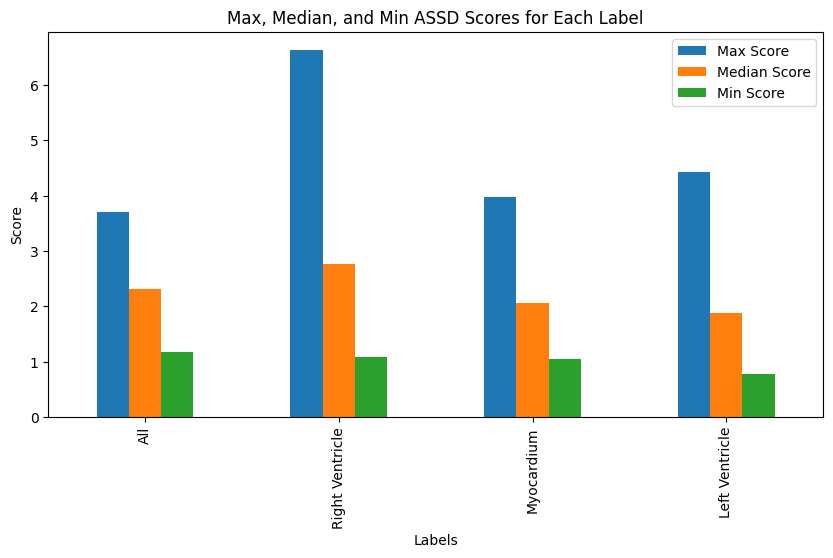

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML

# Define the metrics to plot
metrics = ['Dice', 'Hausdorff', 'ASSD']

# Loop through each metric and create separate tables and plots
for metric in metrics:
    # Filter the DataFrame for the current metric
    df_metric = df.xs(metric, level=0, axis=1)

    # Calculate the best, worst, and median scores for the current metric
    best_scores = df_metric.max()
    median_scores = df_metric.median()
    worst_scores = df_metric.min()

    # Create a DataFrame to display these results
    results_data = {
        "Max Score": best_scores,
        "Median Score": median_scores,
        "Min Score": worst_scores
    }
    results_df = pd.DataFrame(results_data)

    # Display the DataFrame
    display(HTML(f"<h3>{metric} Scores</h3>"))
    display(HTML(results_df.to_html(float_format=lambda x: '%.2f' % x)))

    # Plotting the results
    results_df.plot(kind='bar',figsize=(10, 5))
    plt.title(f'Max, Median, and Min {metric} Scores for Each Label')
    plt.ylabel('Score')
    plt.xlabel('Labels')
    plt.show()

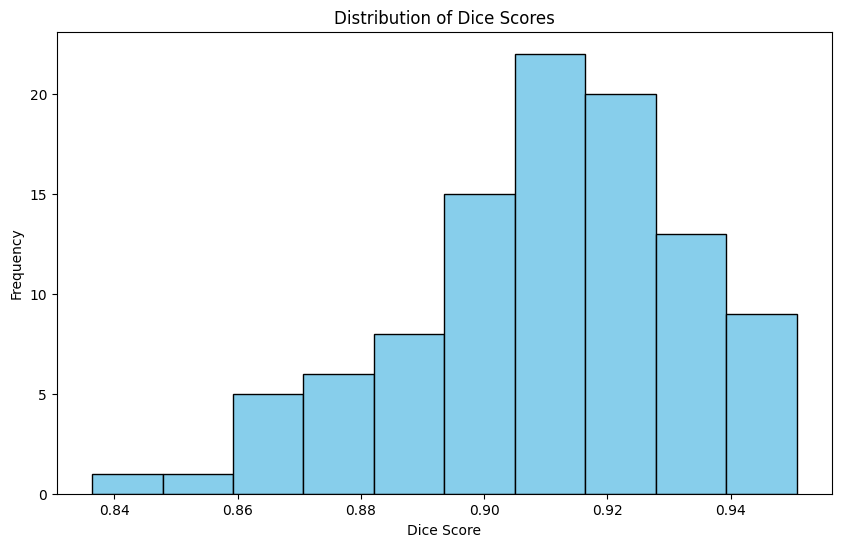

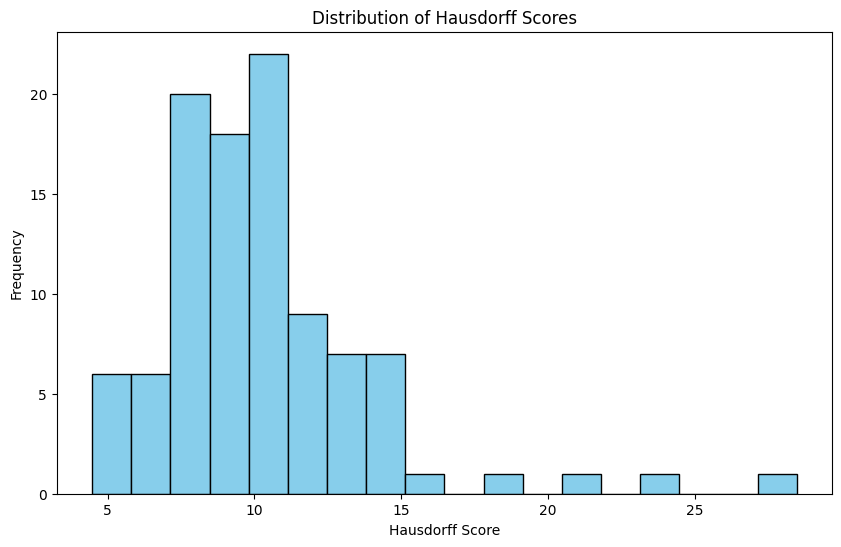

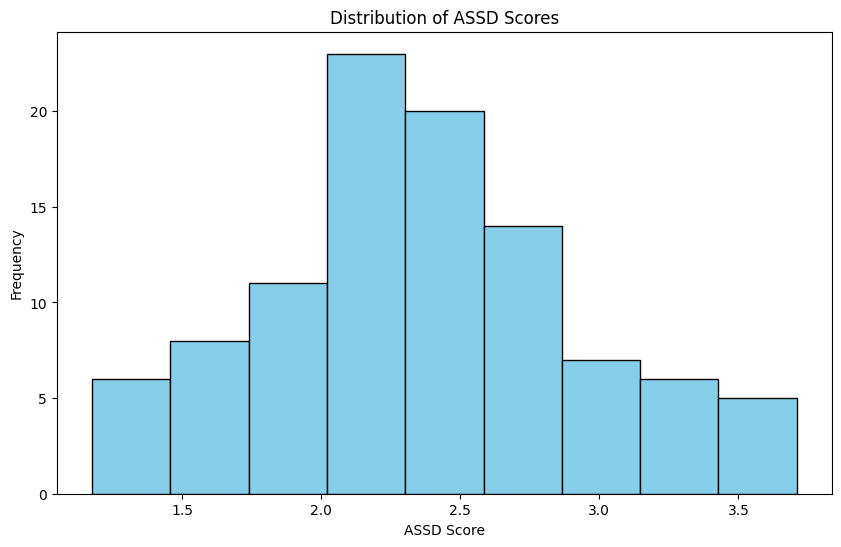

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to drop rows with invalid values
def drop_invalid_rows(df):
    return df.dropna()

# Assuming df is your DataFrame with the scores
df_clean = drop_invalid_rows(df)

# Metrics to plot
metrics = ['Dice', 'Hausdorff', 'ASSD']
label = 'All'  # Assuming you want to plot for the 'all' label

# Plot the distribution of each metric
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.hist(df_clean.loc[:, (metric, label)], bins='auto', color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {metric} Scores')
    plt.xlabel(f'{metric} Score')
    plt.ylabel('Frequency')
    plt.show()

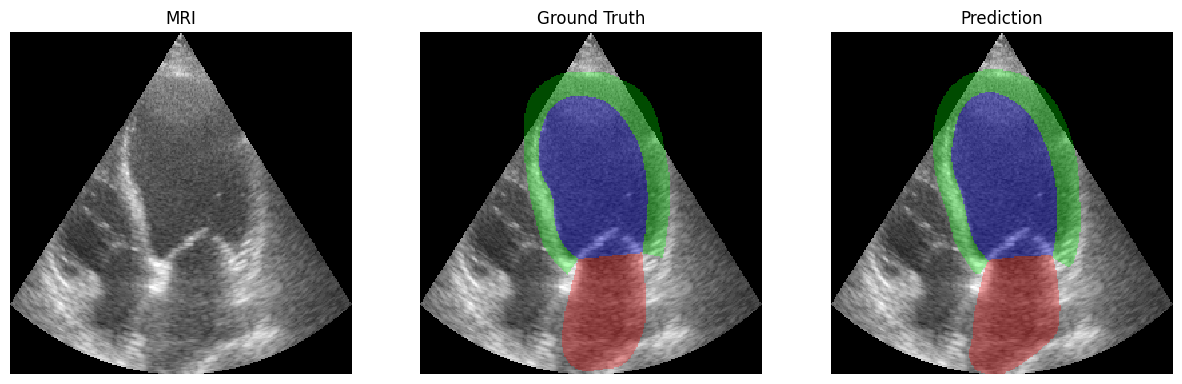

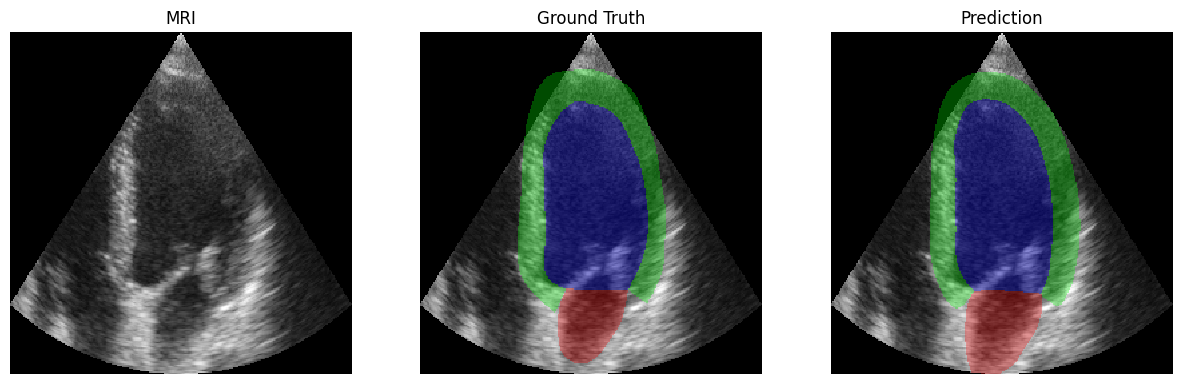

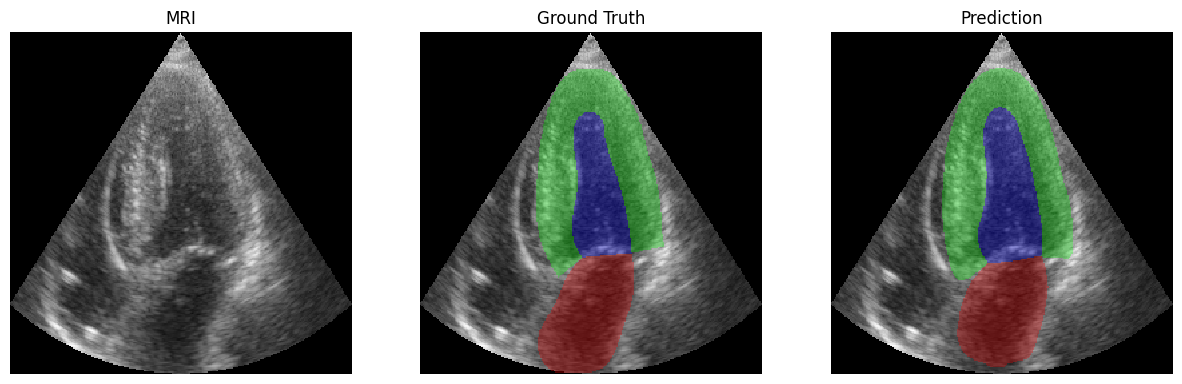

In [30]:
# Select random values
nb_imgs = 3
start_ind = (np.random.randint(0, X_test.shape[0]-nb_imgs, size=1))[0]
end_ind = start_ind+nb_imgs

# Display the random images with the corresponding reference and predicted mask
plot_compare_segmentation(X_test[start_ind:end_ind], y_test[start_ind:end_ind], y_pred[start_ind:end_ind], " ", spacing=(1,1), step=1)